## Load/import packages

In [1]:
import json
import scipy
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

from tensorflow.keras import Sequential, layers
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.utils import class_weight

# Import variables and functions from my own scripts
from functions import plot_history, arr_replacevalue
from load_features import (
    train_features_AW2,
    val_features_AW2,
    train_labels_AW2,
    val_labels_AW2,
    labels_reshaper,
    features_reshaper,
)

%matplotlib inline

# Limit GPU memory usage
for device in tf.config.experimental.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(device, True)

# Prepare data

## Reshape features, labels
The model gets more unstable and validation scores converge later with higher sequence length. Increasing sequence length does not improve the models performance.

In [2]:
# Reshape data to specified sequence length
length = 60
seq_train_features = features_reshaper(train_features_AW2, length)
seq_val_features = features_reshaper(val_features_AW2, length)

seq_train_labels = labels_reshaper(train_labels_AW2, length)
seq_val_labels = labels_reshaper(val_labels_AW2, length)

## Compute sample weights

In [4]:
def comp_sampleweights(labels):
    # Convert one-hot encoded labels back to label integers
    train_label_ints = np.argmax(labels, axis=2)

    # Compute class weights with sklearn
    class_weights = class_weight.compute_class_weight(
        "balanced", np.unique(train_label_ints), train_label_ints.flatten()
    )
    d_class_weights = dict(enumerate(class_weights))

    # Pass a 2D array with shape (samples, sequence_length), to apply a different weight to every timestep of every sample
    return arr_replacevalue(train_label_ints, d_class_weights)
    
train_samples_weights = comp_sampleweights(seq_train_labels)   

# Train + Evaluate model

In [8]:
def build_model():
    # Only tune the first layer of hyperparameters
    model = Sequential(name="RNN-LSTM")
    model.add(
        layers.InputLayer(
            input_shape=(seq_train_features.shape[1], seq_train_features.shape[2])
        )
    )
    model.add(layers.LSTM(128, return_sequences=True, name="LSTM_1"))
    model.add(layers.LayerNormalization())
    model.add(layers.Dense(7, activation="softmax", name="Dense_Output"))
    model.compile(
        optimizer="adagrad",
        loss=CategoricalCrossentropy(label_smoothing=0.1),
        metrics=["accuracy", "AUC"],
    )
    return model

In [9]:
LSTM = build_model()

## Best model results

In [ ]:
# checkpoint_path = "data/models/cp_training_LSTM.ckpt"

# import time
# name = 'LSTM_opt_{}'.format(int(time.time()))
# tb_callback = tf.keras.callbacks.TensorBoard(log_dir='logs/{}'.format(name))

# Access tensorboard in cmd of the main repo folder with following code:
# tensorboard --logdir='logs/'

# # Set callbacks for model training
# csvlog = tf.keras.callbacks.CSVLogger(
#     "data/models/LSTM_performance.csv", separator=",", append=False
# )

# cp_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_path, save_weights_only=True, verbose=1
# )

history_best = LSTM.fit(
    seq_train_features,
    seq_train_labels,
    sample_weight=train_samples_weights,
    validation_data=(seq_val_features, seq_val_labels),
    epochs=100,
#     callbacks=[es, 
#                cp_callback, 
#                csvlog, 
#                tb_callback],
    verbose=2,
)

In [8]:
LSTM.summary()

Model: "RNN-LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_1 (LSTM)                (None, 60, 128)           2425344   
_________________________________________________________________
layer_normalization (LayerNo (None, 60, 128)           256       
_________________________________________________________________
Dense_Output (Dense)         (None, 60, 7)             903       
Total params: 2,426,503
Trainable params: 2,426,503
Non-trainable params: 0
_________________________________________________________________


In [18]:
results = LSTM.evaluate(seq_val_features, seq_val_labels, verbose=0)
print(dict(zip(LSTM.metrics_names, results)))

{'loss': 1.6548638343811035, 'accuracy': 0.48596706986427307, 'f1': 0.4146135747432709, 'auc': 0.8046668171882629}


## Plot the model architecture

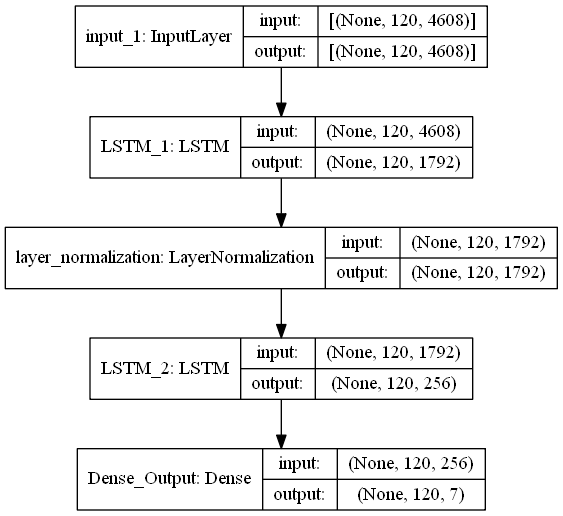

In [19]:
# Plot CNN-LSTM model
tf.keras.utils.plot_model(
    LSTM,
    to_file="images/models/LSTM_architecture.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

## Plot performance of model

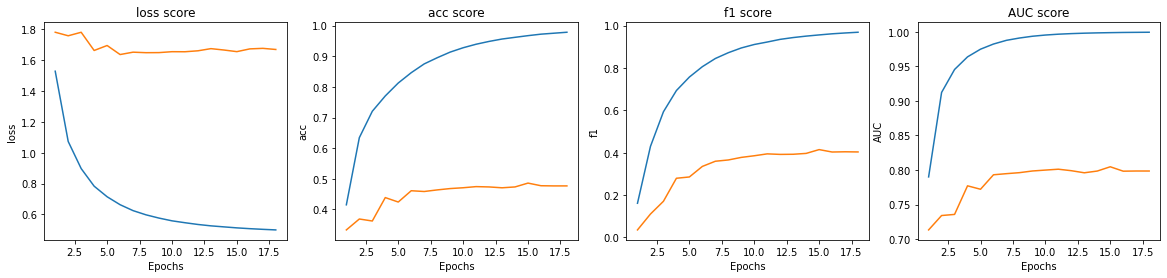

In [20]:
model_hist = history_best.history

labels = [*model_hist.keys()]
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
epochs = range(1, len(model_hist["loss"]) + 1)
for data, label in zip(
    [model_hist["loss"], model_hist["val_loss"]], [labels[0], labels[4]]
):
    axes[0].plot(epochs, data, label=label)

for data, label in zip(
    [model_hist["accuracy"], model_hist["val_accuracy"]], [labels[1], labels[5]]
):
    axes[1].plot(epochs, data, label=label)

for data, label in zip(
    [model_hist["f1"], model_hist["val_f1"]], [labels[2], labels[6]]
):
    axes[2].plot(epochs, data, label=label)

for data, label in zip(
    [model_hist["auc"], model_hist["val_auc"]], [labels[3], labels[7]]
):
    axes[3].plot(epochs, data, label=label)

for i, label in zip(range(4), ["loss", "acc", "f1", "AUC"]):
    axes[i].set_title(label + " score")
    axes[i].set_xlabel("Epochs")
    axes[i].set_ylabel(label)

In [22]:
# Save model performance to json file
with open("data/models/LSTM_performance.json", "w") as fp:
    json.dump(model_hist, fp)

## Save model+weights to folder

In [21]:
# Save model
tf.keras.Model.save(LSTM, filepath="data/models/LSTM_model.h5")

## Calculate precision score with SKlearnbest_LSTM

In [12]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_auc_score

In [22]:
# Load best LSTM model
best_LSTM = tf.keras.models.load_model(
    filepath="data/models/LSTM_model.h5", custom_objects={"F1-metric": f1}, compile=False
)
best_LSTM.compile(
        optimizer="adagrad",
        loss=CategoricalCrossentropy(label_smoothing=0.1),
        metrics=["accuracy", "AUC"],
    )

In [24]:
best_LSTM.evaluate(seq_val_features, seq_val_labels, verbose = 2)

84/84 - 4s - loss: 1.6549 - accuracy: 0.4860 - auc: 0.8047


[1.6548638343811035, 0.48596706986427307, 0.8046668171882629]

In [15]:
# Do predictions on test set
val_pred = best_LSTM.predict(seq_val_features, verbose=0)

# Reshape back to (frame, label)
val_pred = np.reshape(
    val_pred, (val_pred.shape[0] * val_pred.shape[1], val_pred.shape[2])
)

# Convert one hot encoding to integers
val_pred = np.argmax(val_pred, axis=1)

In [16]:
# Reshape back to (frame, label)
val_true = np.reshape(
    seq_val_labels,
    (seq_val_labels.shape[0] * seq_val_labels.shape[1], seq_val_labels.shape[2]),
)
val_true = np.argmax(val_true, axis=1)

In [26]:
# F1 Results with model v3
for avg in [None, "micro", "macro", "weighted"]:
    score = f1_score(val_true, val_pred, average=avg)
    print(f"Average method: {avg}, f1-score: {score}")

Average method: None, f1-score: [0.65032418 0.07200486 0.00685358 0.00510159 0.3405524  0.14001207
 0.28963893]
Average method: micro, f1-score: 0.4859670549918577
Average method: macro, f1-score: 0.2149268019557213
Average method: weighted, f1-score: 0.4665984518325578


# Build HP tuner model

In [4]:
# def build_model(hp):
#     # Only tune the first layer of hyperparameters
#     hp_unit = hp.Int("units", min_value=256, max_value=2048, step=256)

#     model = Sequential(name="RNN-LSTM")
#     model.add(
#         layers.InputLayer(
#             input_shape=(seq_train_features.shape[1], seq_train_features.shape[2])
#         )
#     )
#     model.add(layers.LSTM(hp_unit, return_sequences=True, name="LSTM_1"))
#     model.add(layers.LayerNormalization())
#     model.add(layers.LSTM(256, return_sequences=True, name="LSTM_2"))
#     model.add(layers.Dense(7, activation="softmax", name="Dense_Output"))
#     model.compile(
#         optimizer="adagrad",
#         loss=CategoricalCrossentropy(label_smoothing=0.1),
#         metrics=["accuracy", "AUC"],
#     )
#     return model

## Hyperparameter tuning

In [12]:
# es = tf.keras.callbacks.EarlyStopping(
#             monitor="val_loss",
#             verbose=1,
#             patience=3,
#             mode="max",
#             restore_best_weights=True,
#         )

In [ ]:
# # Keras-tuner setup
# tuner = kt.RandomSearch(
#     build_model,
#     objective="val_loss",
#     max_trials=8,
#     executions_per_trial=5,
#     seed=1337,
#     project_name=normpath("C:/Keras_tuner"),
#     overwrite=True,
# )

# # Check the defined hyperparameter search space
# tuner.search_space_summary()

# # Do random serach for optimal hyperparameters
# tuner.search(
#     seq_train_features,
#     seq_train_labels,
#     sample_weight=train_samples_weights,
#     epochs=100,
#     validation_data=(seq_val_features, seq_val_labels),
#     callbacks=[es],
#     verbose=2,
# )

In [ ]:
tuner.results_summary()

In [ ]:
## Grab optimal hyperparameter
tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

In [ ]:
LSTM = tuner.hypermodel.build(best_hps)
LSTM.summary()